In [1]:
conda activate LegoClassification


Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys, os
import time
import math
import pandas as pd
import numpy as np
import torch
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image, ImageReadMode
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import dataset.data
import dataset.transforms as mT

%matplotlib inline

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'--- using {device} ---\n')

img_path = r'data\renders\\'
classes_path = r'data\RenderedParts.csv' 

classes_df = pd.read_csv(classes_path, header=0)
classes = list(classes_df['Part ID'])

pics_per_iter = 2

cropped_res = 128

batch_size = 128

num_workers = 2 # doesn't work as of now

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(classes_df)

--- using cuda ---

     Rank  Image Part ID                                          Part Name  # Colors  # Pieces
0       1    NaN    4073                                   1×1 Plate, Round        48     38855
1       2    NaN    3023                                          1×2 Plate        52     34615
2       3    NaN    3024                                          1×1 Plate        47     27101
3       4    NaN   98138                                    1×1 Tile, Round        53     25545
4       5    NaN    2780  Technic Pin with Friction Ridges Lengthwise an...         1     21347
..    ...    ...     ...                                                ...       ...       ...
904   995    NaN   53454     Weapon Axe Head, Clip-on (Viking) [Thick Clip]         4        48
905   996    NaN   98549  Tile Special 2 x 2 with Bar and Stud with Stop...         2        48
906   997    NaN   30134                     Stairs 7 x 4 x 6 Straight Open         4        48
907   998    NaN   3

Total: 18091, train: 14980, test: 3111
Input shape: torch.Size([2, 1, 128, 128]), label shape: torch.Size([909])
ID: 22889, name: Slope Inverted 45┬░ 6 x 2 Double with 2 x 4 Cutout


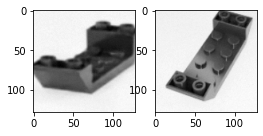

In [9]:
transform_load = T.Compose([
    T.Resize((cropped_res, cropped_res)),
    T.Lambda(lambda img: img / 255)
])

transform_get = T.Compose([
    mT.BatchRandomHorizontalFlip(p=0.5),
    T.RandomErasing(p=0.33, scale=(0.01, 0.1)),
    T.GaussianBlur(5, sigma=(0.0001, 0.03)),
    T.ColorJitter(brightness=0.15, contrast=0.1),
    T.RandomResizedCrop(size=cropped_res, scale=(0.75,1.1), ratio=(0.85,1.176)),
    mT.RandomNoise(std=(0.001, 0.01)),
    T.Normalize(mean=0.485, std=0.229)
])

all_data = dataset.data.PartDataset(
    classes=classes, 
    img_dir=img_path, 
    pics_per_iter=pics_per_iter, 
    transform_load=transform_load, 
    transform_get=transform_get, 
    bg_subtract_renders=False, 
    render_crop_pad=0,
    gray=True,
    bg_subtract_real=True, 
    real_crop_pad=10, 
    use_cache=True)

trainset, testset = dataset.data.PartDataset.train_test_split(all_data, train_split=0.8)

print(f'Total: {len(all_data)}, train: {len(trainset)}, test: {len(testset)}')
print(f'Input shape: {trainset[0][0].shape}, label shape: {trainset[0][1].shape}')

num = 10000
dataset.data.show_img_iter(all_data[num][0], size=4, gray=all_data.gray)
label_num = torch.where(all_data[num][1])[0][0].item()
part_id = classes_df['Part ID'][label_num]
part_name = classes_df['Part Name'][label_num]
print(f'ID: {part_id}, name: {part_name}')

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [8]:
class LegoClassifier(nn.Module):
    def __init__(self, extra_layer=False):
        super().__init__()
        self.extra_layer = extra_layer
        
        self.net1 = torch.hub.load('pytorch/vision:v0.11.3', 'resnet18', pretrained=False)
        self.net2 = torch.hub.load('pytorch/vision:v0.11.3', 'resnet18', pretrained=False)
        
        self.net1.fc = nn.Linear(in_features=512, out_features=len(classes), bias=True)
        self.net2.fc = nn.Linear(in_features=512, out_features=len(classes), bias=True)
        
        self.net1.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.net2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        if self.extra_layer:
            self.drop = nn.Dropout(p=0.5)
            self.fc = nn.Linear(in_features=len(classes)*pics_per_iter, out_features=len(classes), bias=True)
        
    def forward(self, inputs):
        inp1 = inputs[:,0].to(device)
        inp2 = inputs[:,1].to(device)
        
        out1 = self.net1(inp1)
        out2 = self.net2(inp2)
        
        if self.extra_layer:
            outputs = torch.cat((out1, out2), dim=1)
            outputs = self.drop(outputs)
            outputs = self.fc(outputs)
        else:
            outputs = (out1 + out2) / 1000
        
        return outputs

net = LegoClassifier(extra_layer=True)
net.to(device)
print()

Using cache found in C:\Users\sokfi/.cache\torch\hub\pytorch_vision_v0.11.3
Using cache found in C:\Users\sokfi/.cache\torch\hub\pytorch_vision_v0.11.3


In [9]:
loss_func = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net.train()

total_loss = 0
print_freq = 32

for epoch in range(5):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_func(outputs, labels.to(device))
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        
        if torch.any(torch.isnan(outputs)):
            raise Exception('Nan output')
        
        if i % print_freq == 0:
            print(f'[{epoch+1}][{i}] cur: {loss.item()}, avg: {total_loss / print_freq}, out max: {torch.max(abs(outputs))}, out mean: {torch.mean(outputs)}')
            total_loss = 0

print('done')

In [18]:
torch.save(net.state_dict(), 'model.pth')

In [10]:
net.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [11]:
net.eval()

with torch.no_grad():
    class_acc = {x for x in classes}
    total = 0
    correct = 0
    correct_top5 = 0

    for i, data in enumerate(testloader):
        inputs, labels = data
        total += inputs.shape[0]
        
        outputs = net(inputs)
        
        _, top5 = torch.topk(outputs.data, k=5, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        labels = labels.to(device)
        
        correct += (predicted == labels).sum().item()
        correct_top5 += torch.any(torch.where(top5 == labels.unsqueeze(1), True, False), dim=1).sum().item()
    
    print(f'Predicted {correct}/{len(testset)} items')
    print(f'Top 1: {(float(correct) / len(testset)) * 100.0}%')
    print(f'Top 5: {(float(correct_top5) / len(testset)) * 100.0}%')

Predicted 2580/3111 items
Top 1: 82.93153326904532%
Top 5: 96.14271938283511%


tensor([[330, 885,   7,  89, 589]], device='cuda:0')
Panel 1 x 6 x 5
Slope 10┬░ 6 x 8
1×1 Slope 30° (Cheese)
Brick 1 x 2 x 2 with Inside Stud Holder
Cylinder Half 2 x 4 x 4


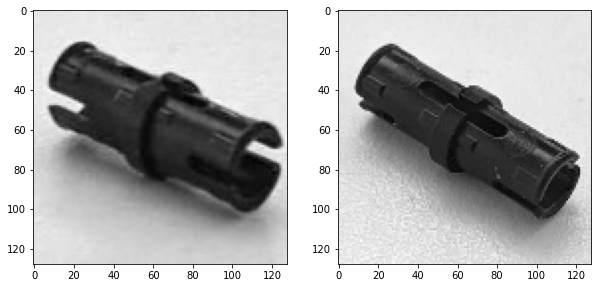

In [ ]:
empty = read_image(r'data\real\0.jpeg', mode=ImageReadMode.GRAY) 
img1 = read_image(r'data\real\1_11.jpeg', mode=ImageReadMode.GRAY) 
img2 = read_image(r'data\real\1_22.jpeg', mode=ImageReadMode.GRAY)

images = torch.stack((jitter(transform_gray(img1)), transform_gray(img2)))
#crop = dataset.data.get_square_cropped_img_iter(imgs, real=True, empty_img=empty)

dataset.data.show_img_iter(images, size=10, gray=True)

outputs = net(images.unsqueeze(0))

_, top5 = torch.topk(outputs.data, k=5, dim=1)
print(top5)
for x in top5.squeeze(0):
    print(classes_df['Part Name'][x.item()])

In [17]:
net.eval()

with torch.no_grad():
    total = 0
    correct = 0
    correct_top5 = 0

    for i, data in enumerate(trainloader):
        inputs, labels = data
        total += inputs.shape[0]
        
        outputs = net(inputs)
        
        _, top5 = torch.topk(outputs.data, k=5, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        labels = labels.to(device)
        
        correct += (predicted == labels).sum().item()
        correct_top5 += torch.any(torch.where(top5 == labels.unsqueeze(1), True, False), dim=1).sum().item()
    
    print(f'Predicted {correct}/{len(trainset)} items')
    print(f'Top 1: {(float(correct) / len(trainset)) * 100.0}%')
    print(f'Top 5: {(float(correct_top5) / len(trainset)) * 100.0}%')

Predicted 14177/14980 items
Top 1: 94.63951935914552%
Top 5: 99.59946595460613%


In [25]:
torch.cuda.empty_cache() 